In [4]:
from phimal_utilities.analysis import load_tensorboard
import matplotlib.pyplot as plt

In [5]:
df = load_tensorboard('data/noise_0.0_run_0/')

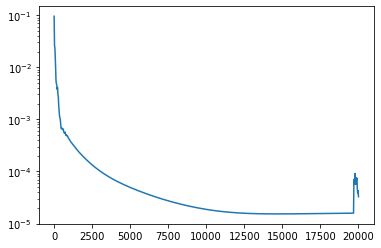

In [7]:
plt.semilogy(df.index, df['remaining_loss_test'])

In [8]:
df['remaining_loss_test'].idxmin()

14675

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
# General imports
import numpy as np
import torch

# DeepMoD stuff
from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import NN
from deepymod_torch.model.library import Library1D
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import Clustering, Threshold
from deepymod_torch.training import train_split_full
from deepymod_torch.training.sparsity_scheduler import Periodic, TrainTestPeriodic

from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta

if torch.cuda.is_available():
    device ='cuda'
else:
    device = 'cpu'

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Making dataset
v = 0.1
A = 1.0

x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(BurgersDelta, v=v, A=A)


# Defining model

network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

X, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=2000, noise=0.0, random=True, normalize=False)
X, y = X.to(device), y.to(device)

sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=8) # in terms of write iterations
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True, lr=2e-3) # Defining optimizer

train_split_full(model, X, y, optimizer, sparsity_scheduler, split=0.8, test='full', log_dir=f'runs/not_triggering_fixed/', write_iterations=25, max_iterations=20000, delta=0.001, patience=4) # Running


| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
      15775     78.88%             144s   5.21e-06   1.18e-06   4.03e-06   1.47e+00 Algorithm converged. Stopping training.
